In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
#torch.multiprocessing.set_start_method('spawn')
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import ConcatDataset, DataLoader
from catalyst import dl
from catalyst.utils import metrics
from torch.nn import functional as F
from catalyst.dl import AlchemyLogger

import vxs

/home/flyingleafe/vxs-vpt/pythonenv/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
PAD_TRACK_LEN = 4096*8
CUT_FRAME_WINDOW = 4096*4
PAD_SPECGRAM = PAD_TRACK_LEN // 512

vocal_sketch_dataset = vxs.SampleSet(glob.glob('../data/vocal-sketch/interactiveaudiolab-VocalSketchDataSet-6c9f381/vocal_imitations/included/*.wav'),
                                     pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
drum_machines_dataset = vxs.SampleSet(glob.glob('../data/200-drum-machines/drums/*/*.wav'),
                                      pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
avp_set_fixed = vxs.SampleSet(tracks=vxs.SegmentSet(vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Fixed'),
                                                    frame_window=CUT_FRAME_WINDOW, return_class=False),
                              pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset, avp_set_fixed])

In [8]:
len(common_set)

15995

In [9]:
len(drum_machines_dataset)

6749

In [10]:
len(vocal_sketch_dataset)

4429

In [6]:
%%time
# Pre-caching all the specgrams
for i in tqdm(range(len(common_set))):
    _ = common_set[i]

100%|██████████| 15649/15649 [07:33<00:00, 34.47it/s]

CPU times: user 17min 55s, sys: 11min 45s, total: 29min 40s
Wall time: 7min 33s


In [11]:
class ConvAERunner(dl.Runner):
    def _handle_batch(self, batch):
        x = batch          # ignore the raw waveform
        y, z = self.model(x)
        loss = F.mse_loss(y, x)
        self.batch_metrics = {
            'loss': loss
        }
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
def alchemy_logger(group, name):
    return AlchemyLogger(
        token="1da39325aff8856a81d7ad0250c9f921",
        project="default",
        experiment=name,
        group=group,
        log_on_epoch_end=False
    )

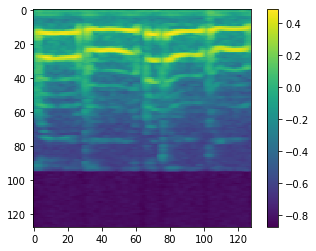

torch.Size([128, 128])


In [4]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx]
        ax.imshow(sample.cpu().squeeze(0).numpy())
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    model_device = next(model.parameters()).device
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx].to(model_device)
        sample_out, z = model(sample.unsqueeze(0))
        ax1.imshow(sample.squeeze().cpu().numpy())
        ax2.imshow(sample_out.detach().squeeze().cpu().numpy())
        ax3.imshow(z.detach().squeeze().cpu().numpy().reshape(16, -1))
        
    plt.show()
    
melgram = common_set[42][0]
im = plt.imshow(melgram.cpu().squeeze(0).numpy())
plt.colorbar(im)
plt.show()
print(melgram.shape)

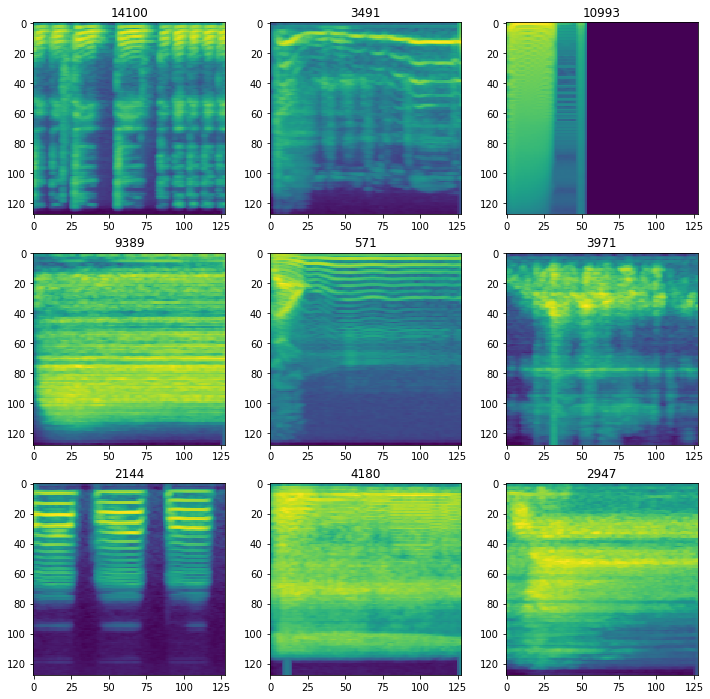

In [5]:
imshow_random_samples(common_set, 9, random_seed=44, cols=3)

In [12]:
splitter = vxs.DataSplit(common_set, shuffle=True, test_train_split=1)
loaders = {
    'train': splitter.get_train_loader(),
    'valid': splitter.get_validation_loader()
}

model = vxs.ConvAE(padding_mode='zeros')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
runner = ConvAERunner()
runner.train(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir=f"../logs/conv_ae_square_frame_{PAD_TRACK_LEN}_{CUT_FRAME_WINDOW}"
)

<frozen importlib._bootstrap>:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



Early exiting                                                        
1/10 * Epoch (train):   1% 4/288 [00:23<27:16,  5.76s/it, loss=0.493]

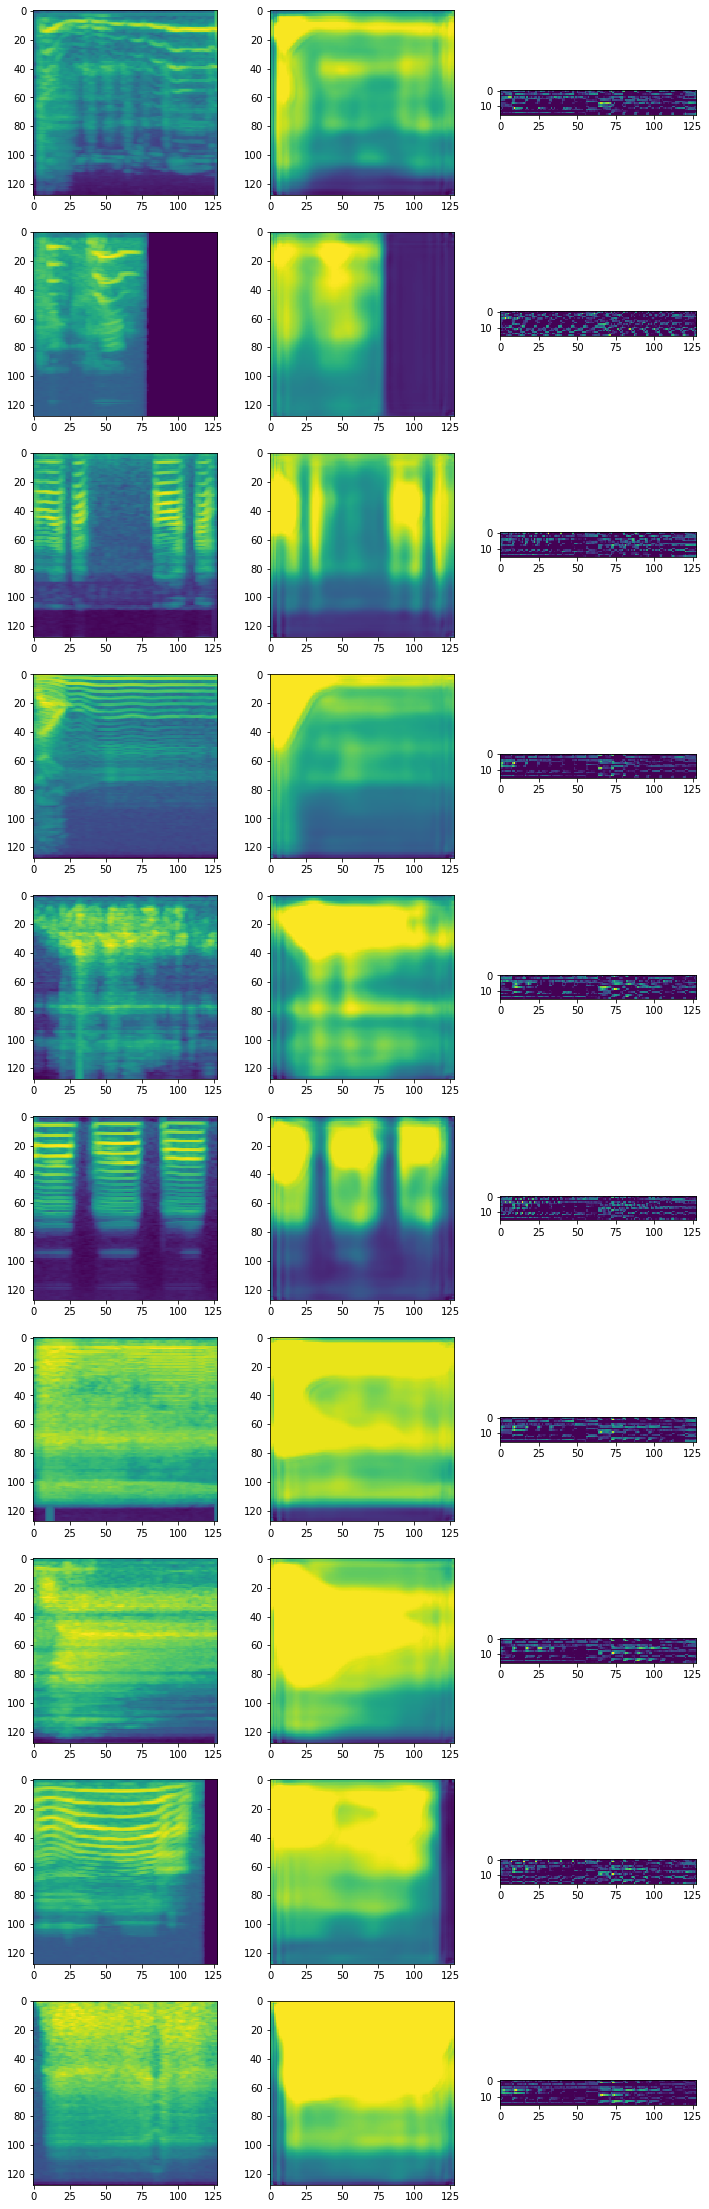

In [27]:
model.load_state_dict(torch.load(
    '../logs/conv_ae_square_frame_65536_65536/checkpoints/best.pth')['model_state_dict'])
model.eval()
imshow_ae_output(model, vocal_sketch_dataset, 10, random_seed=44)

In [11]:
model_wide = vxs.ConvAE(outer_kernel_size=(3,5), strides=[(2,2),(4,2),(4,2),(4,4)], padding_mode='zeros')
optimizer_wide = torch.optim.Adam(model_wide.parameters(), lr=0.001)

In [14]:
runner = ConvAERunner()
runner.train(
    model=model_wide, 
    optimizer=optimizer_wide, 
    loaders=loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir=f"../logs/conv_ae_wide_frame_{PAD_TRACK_LEN}_{CUT_FRAME_WINDOW}",
    #callbacks={'alchemy_logger': alchemy_logger('CAEs', f'cae_wide_frame_{PAD_TRACK_LEN}_{CUT_FRAME_WINDOW}')}
)

1/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.82it/s, loss=0.007]
1/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.18it/s, loss=0.010]
[2020-07-21 01:48:32,896] 
1/10 * Epoch 1 (train): loss=0.0079
1/10 * Epoch 1 (valid): loss=0.0073


INFO:metrics_logger:
1/10 * Epoch 1 (train): loss=0.0079
1/10 * Epoch 1 (valid): loss=0.0073


2/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.88it/s, loss=0.010]
2/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.45it/s, loss=0.011]
[2020-07-21 01:48:55,942] 
2/10 * Epoch 2 (train): loss=0.0081
2/10 * Epoch 2 (valid): loss=0.0097


INFO:metrics_logger:
2/10 * Epoch 2 (train): loss=0.0081
2/10 * Epoch 2 (valid): loss=0.0097


3/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.88it/s, loss=0.009]
3/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.19it/s, loss=0.006]
[2020-07-21 01:49:18,969] 
3/10 * Epoch 3 (train): loss=0.0082
3/10 * Epoch 3 (valid): loss=0.0069


INFO:metrics_logger:
3/10 * Epoch 3 (train): loss=0.0082
3/10 * Epoch 3 (valid): loss=0.0069


4/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.86it/s, loss=0.009]
4/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 29.82it/s, loss=0.008]
[2020-07-21 01:49:42,094] 
4/10 * Epoch 4 (train): loss=0.0078
4/10 * Epoch 4 (valid): loss=0.0075


INFO:metrics_logger:
4/10 * Epoch 4 (train): loss=0.0078
4/10 * Epoch 4 (valid): loss=0.0075


5/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.87it/s, loss=0.006]
5/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.58it/s, loss=0.006]
[2020-07-21 01:50:05,129] 
5/10 * Epoch 5 (train): loss=0.0075
5/10 * Epoch 5 (valid): loss=0.0070


INFO:metrics_logger:
5/10 * Epoch 5 (train): loss=0.0075
5/10 * Epoch 5 (valid): loss=0.0070


6/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.87it/s, loss=0.008]
6/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.60it/s, loss=0.007]
[2020-07-21 01:50:28,154] 
6/10 * Epoch 6 (train): loss=0.0075
6/10 * Epoch 6 (valid): loss=0.0067


INFO:metrics_logger:
6/10 * Epoch 6 (train): loss=0.0075
6/10 * Epoch 6 (valid): loss=0.0067


7/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.85it/s, loss=0.006]
7/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.46it/s, loss=0.006]
[2020-07-21 01:50:51,209] 
7/10 * Epoch 7 (train): loss=0.0072
7/10 * Epoch 7 (valid): loss=0.0068


INFO:metrics_logger:
7/10 * Epoch 7 (train): loss=0.0072
7/10 * Epoch 7 (valid): loss=0.0068


8/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.86it/s, loss=0.006]
8/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.28it/s, loss=0.010]
[2020-07-21 01:51:14,253] 
8/10 * Epoch 8 (train): loss=0.0072
8/10 * Epoch 8 (valid): loss=0.0064


INFO:metrics_logger:
8/10 * Epoch 8 (train): loss=0.0072
8/10 * Epoch 8 (valid): loss=0.0064


9/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.86it/s, loss=0.007]
9/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 29.93it/s, loss=0.008]
[2020-07-21 01:51:37,370] 
9/10 * Epoch 9 (train): loss=0.0071
9/10 * Epoch 9 (valid): loss=0.0069


INFO:metrics_logger:
9/10 * Epoch 9 (train): loss=0.0071
9/10 * Epoch 9 (valid): loss=0.0069


10/10 * Epoch (train): 100% 282/282 [00:21<00:00, 12.87it/s, loss=0.007]
10/10 * Epoch (valid): 100% 32/32 [00:01<00:00, 30.51it/s, loss=0.007]
[2020-07-21 01:52:00,420] 
10/10 * Epoch 10 (train): loss=0.0081
10/10 * Epoch 10 (valid): loss=0.0069


INFO:metrics_logger:
10/10 * Epoch 10 (train): loss=0.0081
10/10 * Epoch 10 (valid): loss=0.0069


Top best models:
../logs/conv_ae_wide_frame_65536_65536/checkpoints/train.8.pth	0.0064


In [15]:
model_wide.load_state_dict(torch.load('../logs/conv_ae_wide_frame_65536_65536/checkpoints/best.pth')['model_state_dict'])


<All keys matched successfully>

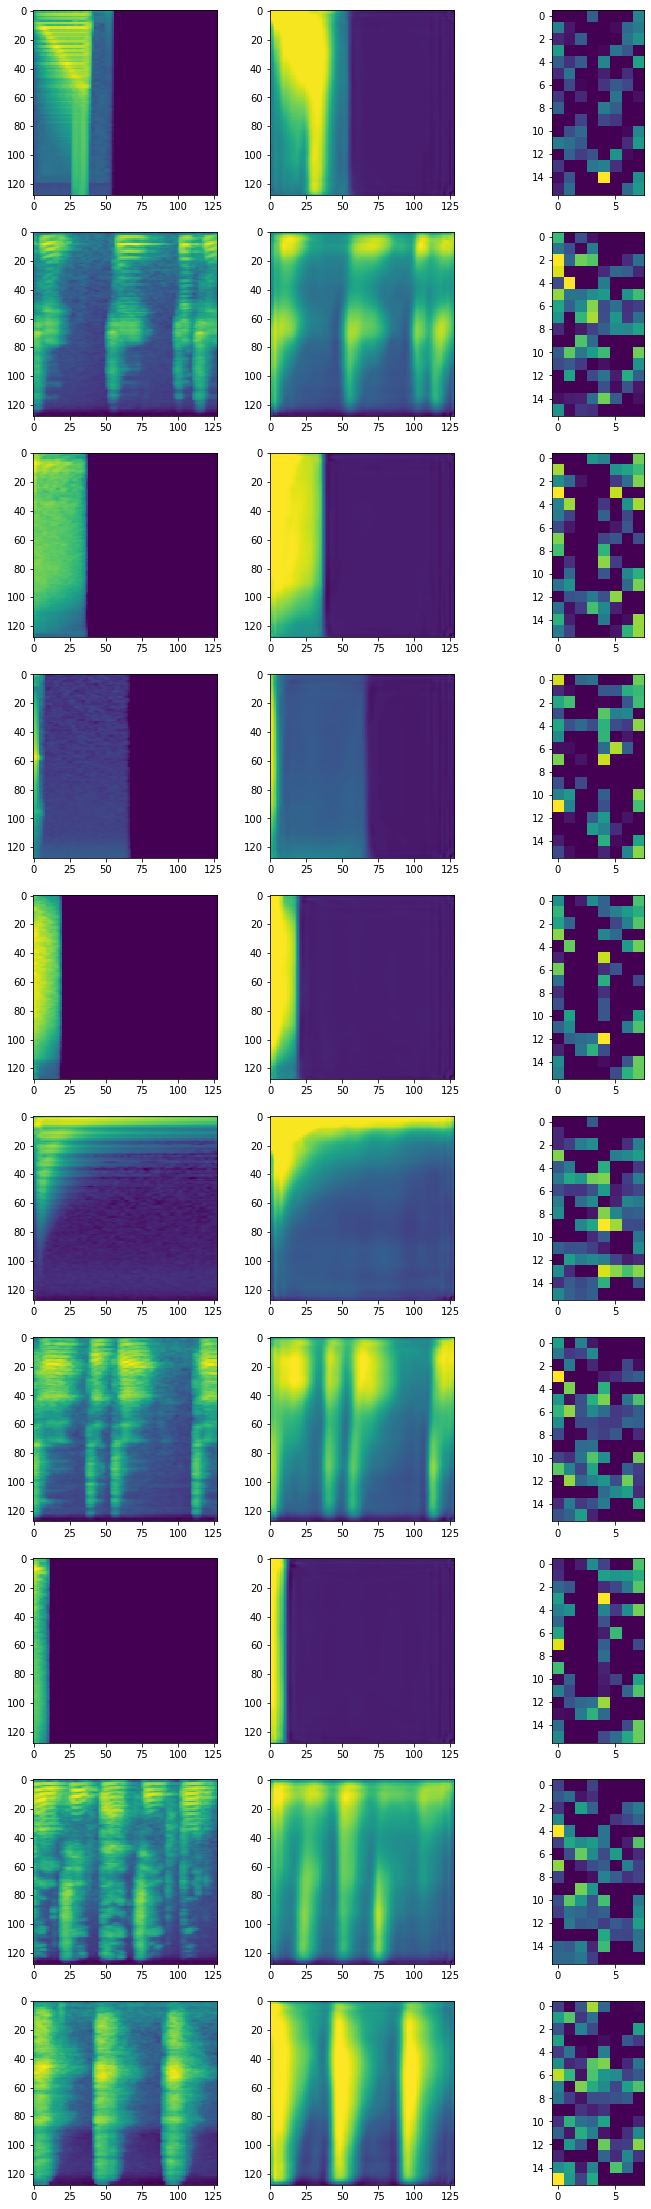

In [16]:
model_wide.eval()
imshow_ae_output(model_wide, common_set, 10, random_seed=455)